# AWS Glue Studio Notebook
##### You are now running a AWS Glue Studio notebook; To start using your notebook you need to start an AWS Glue Interactive Session.


#### Optional: Run this cell to see available notebook commands ("magics").


In [1]:
#%help

In [2]:
#import os

#mysql_jar = "/opt/aws/glue/lib/mysql-connector-java-8.0.23.jar"
#os.environ['PYSPARK_SUBMIT_ARGS'] = f'--jars {mysql_jar} pyspark-shell'

#print( os.environ['PYSPARK_SUBMIT_ARGS'] )

In [3]:
!pip install tldextract

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


####  Run this cell to set up and start your interactive session.


In [4]:
#%idle_timeout 2880
#%glue_version 5.0
#%worker_type G.1X
#%number_of_workers 5

import sys
from awsglue.transforms import *
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from awsglue.context import GlueContext
from awsglue.job import Job
from pyspark.sql import SparkSession

# JDBC_JAR_PATH = "/opt/aws/glue/lib/mysql-connector-j-9.2.0.jar"

sc = SparkContext.getOrCreate()
glueContext = GlueContext(sc)
spark = glueContext.spark_session
job = Job(glueContext)

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/home/glue_user/spark/jars/log4j-slf4j-impl-2.17.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/home/glue_user/spark/jars/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/home/glue_user/aws-glue-libs/jars/log4j-slf4j-impl-2.17.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/home/glue_user/aws-glue-libs/jars/slf4j-reload4j-1.7.36.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
/home/glue_user/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getO

#### Extract DynamicFrames from an AWS Glue Data Catalog and display their schemas

In [5]:
import boto3

glue = boto3.client('glue')

database_name = 'fraud-detection-gluedb'

# Obtener las tablas de la base de datos especificada
response = glue.get_tables(DatabaseName=database_name)

datatables = response['TableList']

print([e['Name'] for e in datatables])

['fraud_detection_certs', 'fraud_detection_payment_methods', 'fraud_detection_review', 'fraud_detection_shops', 'fraud_detection_ssl_issuer']


In [6]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret():

    secret_name = "prod/fraud-detection-db"
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )
    
    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        # For a list of exceptions thrown, see
        # https://docs.aws.amazon.com/secretsmanager/latest/apireference/API_GetSecretValue.html
        raise e

    secret = get_secret_value_response['SecretString']
    return json.loads(secret)


In [7]:
import boto3

connection_mysql_options = lambda dbtable : {
    "url": f"jdbc:mysql://{get_secret()['host']}:{get_secret()['port']}/fraud-detection", 
    "dbtable": dbtable, 
    "user": get_secret()["username"], 
    "password": get_secret()["password"], 
    "customJdbcDriverS3Path": "s3://fraud-detection-data-ars/mysql-connector-java-8.0.23.jar",
    "customJdbcDriverClassName": "com.mysql.cj.jdbc.Driver"
}

# Crear un cliente de Glue
glue = boto3.client('glue')

database_name = 'fraud-detection-gluedb'

# Obtener las tablas de la base de datos especificada
response = glue.get_tables(DatabaseName=database_name)

datatables = response['TableList']

local_flag=True

dyf_set = dict()
for name in datatables:
    table_name = name['Name'].removeprefix("fraud_detection_")
    print(f"Table {table_name}")
    
    # fixed access with from_catalog from docker container
    if local_flag: # USING DOCKER IMAGE
        dyf_set[table_name] = glueContext.create_dynamic_frame.from_options(connection_type="mysql", connection_options=connection_mysql_options(table_name.upper()))
        dyf_set[table_name].printSchema()
    else: # IN AWS PLATFORM
        dyf_set[table_name] = glueContext.create_dynamic_frame.from_catalog(database=database_name, table_name=name['Name'])
        dyf_set[table_name].printSchema()


Table certs
Exception while setting endpoint config: java.lang.NullPointerException
root
|-- cert_id: int
|-- cert_expire_date: timestamp
|-- shop_id: int
|-- ssl_id: int

Table payment_methods
root
|-- payment_method_id: int
|-- allow_credit_card: boolean
|-- allow_money_back: boolean
|-- allow_cash_on_delivery: boolean
|-- allow_crypto: boolean
|-- shop_id: int

Table review
root
|-- review_id: int
|-- trust_pilot_score: int
|-- site_jabber_review: boolean
|-- tranco_rank: int
|-- shop_id: int

Table shops
root
|-- shop_id: int
|-- domain_url: string
|-- domain_registration_date: timestamp
|-- is_young_domain: boolean
|-- contact_email: boolean
|-- logo_url: boolean
|-- legitimate: boolean

Table ssl_issuer
root
|-- ssl_id: int
|-- ssl_issuer: string
|-- ssl_organization: string



#### Convert the DynamicFrame to a Spark DataFrame and display a sample of the data

In [8]:
df_set = dict()

for table_name, dyf in dyf_set.items():
    df_set[table_name] = dyf.toDF()
    print(f"Table {table_name}")
    df_set[table_name].show(5)

Table certs


/home/glue_user/spark/python/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+-------+-------------------+-------+------+
|cert_id|   cert_expire_date|shop_id|ssl_id|
+-------+-------------------+-------+------+
|    777|2023-10-24 13:20:41|    777|     3|
|    954|2023-09-13 20:01:27|    954|     2|
|     60|2023-09-18 20:00:40|     60|     2|
|    206|2023-09-05 04:24:48|    206|     2|
|    427|2023-10-17 08:48:18|    427|     3|
+-------+-------------------+-------+------+
only showing top 5 rows

Table payment_methods


+-----------------+-----------------+----------------+----------------------+------------+-------+
|payment_method_id|allow_credit_card|allow_money_back|allow_cash_on_delivery|allow_crypto|shop_id|
+-----------------+-----------------+----------------+----------------------+------------+-------+
|             1052|             true|            true|                 false|       false|   1052|
|               80|             true|            true|                 false|       false|     80|
|              214|             true|            true|                 false|       false|    214|
|              561|            false|            true|                 false|       false|    561|
|              979|             true|           false|                  true|       false|    979|
+-----------------+-----------------+----------------+----------------------+------------+-------+
only showing top 5 rows

Table review


+---------+-----------------+------------------+-----------+-------+
|review_id|trust_pilot_score|site_jabber_review|tranco_rank|shop_id|
+---------+-----------------+------------------+-----------+-------+
|      579|             null|             false|         -1|    579|
|      225|               -1|             false|         -1|    225|
|     1095|             null|             false|         -1|   1095|
|      826|               -1|             false|         -1|    826|
|      144|               -1|             false|         -1|    144|
+---------+-----------------+------------------+-----------+-------+
only showing top 5 rows

Table shops


+-------+--------------------+------------------------+---------------+-------------+--------+----------+
|shop_id|          domain_url|domain_registration_date|is_young_domain|contact_email|logo_url|legitimate|
+-------+--------------------+------------------------+---------------+-------------+--------+----------+
|    709| https://ikonisch.pt|                    null|           true|         true|    true|      true|
|    186|https://www.gowbl...|     2023-06-23 05:43:00|           true|         true|    true|     false|
|   1115|https://www.maxim...|     2000-10-26 00:00:00|          false|         true|    true|      true|
|   1072|https://www.enigm...|     2023-05-29 00:00:00|           true|        false|    true|     false|
|    268|https://www.footw...|     2023-04-20 00:00:00|           true|        false|   false|     false|
+-------+--------------------+------------------------+---------------+-------------+--------+----------+
only showing top 5 rows

Table ssl_issuer


+------+--------------------+----------------+
|ssl_id|          ssl_issuer|ssl_organization|
+------+--------------------+----------------+
|    31|GeoTrust TLS RSA ...|    DigiCert Inc|
|    37|Thawte EV RSA CA ...|    DigiCert Inc|
|     3|                  E1|   Let's Encrypt|
|     1|Cloudflare Inc EC...|Cloudflare, Inc.|
|    35|GeoTrust Global T...|    DigiCert Inc|
+------+--------------------+----------------+
only showing top 5 rows



### Join dataframes

In [9]:
data = df_set["shops"].join(
    df_set["payment_methods"], 
    "shop_id", "left"
).drop("payment_method_id")

data = data.join(
    df_set["review"],
    "shop_id", "left"
).drop("review_id")

tmp = df_set["ssl_issuer"].join(
    df_set["certs"],
    "ssl_id", "left"
).drop("cert_id").drop("ssl_id")

data = data.join(
    tmp,
    "shop_id", "left"
)

data.toPandas()

/home/glue_user/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/home/glue_user/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,shop_id,domain_url,domain_registration_date,is_young_domain,contact_email,logo_url,legitimate,allow_credit_card,allow_money_back,allow_cash_on_delivery,allow_crypto,trust_pilot_score,site_jabber_review,tranco_rank,ssl_issuer,ssl_organization,cert_expire_date
0,496,https://delozastore.de,NaT,True,True,True,False,False,True,False,False,NaN,False,-1,R3,Let's Encrypt,2023-09-25 07:13:20
1,1005,https://www.barnesandnoble.com,1995-08-10 04:00:00,False,False,True,True,False,False,False,False,4.0,True,-1,DigiCert TLS RSA SHA256 2020 CA1,DigiCert Inc,2024-06-06 23:59:59
2,744,https://www.chicballus.com,2023-05-09 01:57:00,True,False,True,False,True,True,False,False,NaN,False,-1,GTS CA 1P5,Google Trust Services LLC,2023-10-05 06:20:16
3,811,https://www.usridingapparel.com,2023-07-26 03:37:00,True,False,True,False,True,True,False,False,NaN,False,-1,E1,Let's Encrypt,2023-10-24 03:01:26
4,474,http://www.aloevera.lt,2014-12-09 00:00:00,False,True,True,True,True,False,False,False,-1.0,False,-1,R3,Let's Encrypt,2023-10-24 20:17:04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,154,https://www.sprintis.eu,NaT,True,False,True,True,True,True,True,False,-1.0,False,-1,Cloudflare Inc ECC CA-3,"Cloudflare, Inc.",2024-04-09 23:59:59
1136,1119,https://store.dji.com/l,1996-01-16 05:00:00,False,True,True,True,True,True,False,False,2.0,False,-1,Amazon RSA 2048 M01,Amazon,2024-01-25 23:59:59
1137,856,https://stact.de,NaT,True,True,True,True,True,True,False,False,-1.0,False,-1,R3,Let's Encrypt,2023-09-05 16:28:11
1138,1129,https://www.knitwearonlienshop.com,2023-07-27 04:53:00,True,False,True,False,True,True,True,False,NaN,False,-1,E1,Let's Encrypt,2023-10-25 04:12:15


#### Feature engineering

In [10]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
import re
import tldextract
from urllib.parse import urlparse

In [11]:

@udf(ArrayType(StringType()))
def separate_domain(ss):
    if not ss or not isinstance(ss, str):  # Manejo de valores nulos o no cadena
        return ["", "", "", ""]
    
    url = urlparse(ss)
    domain = tldextract.extract(url.netloc if url.netloc else url.path)

    return [url.scheme, domain.subdomain, domain.domain, domain.suffix]

new_data = data\
    .withColumn("domain_length", length(col("domain_url"))) \
    .withColumn("character_length", length( regexp_replace(col("domain_url"), "[^a-zA-Z]", "") ) )  \
    .withColumn("digit_length", length( regexp_replace(col("domain_url"), "[^0-9]", "") ) )  \
    .withColumn("has_www", col("domain_url").contains("www")) \
    .withColumn("number_points", length( regexp_replace(col("domain_url"), "[^\.]", "")) ) \
    .withColumn("domain_struct", separate_domain( col("domain_url")) ) \
    .withColumn("scheme", col("domain_struct").getItem(0) ) \
    .withColumn("subdomain", col("domain_struct").getItem(1) ) \
    .withColumn("domain", col("domain_struct").getItem(2) ) \
    .withColumn("prefix", col("domain_struct").getItem(3) ) \
    .withColumn("url_len", length(col("domain_url")) ) \
    .withColumn("domain_len", length(col("domain")) ) \
    \
    .withColumn("domain_registration_year", year(col("domain_registration_date")) ) \
    .withColumn("domain_registration_month", month(col("domain_registration_date")) ) \
    .withColumn("domain_registration_day", dayofmonth(col("domain_registration_date")) ) \
    .withColumn("domain_registration_hour", hour(col("domain_registration_date")) ) \
    .withColumn("domain_registration_min", minute(col("domain_registration_date")) ) \
    \
    .withColumn("cert_expire_date_year", year(col("cert_expire_date")) ) \
    .withColumn("cert_expire_date_month", month(col("cert_expire_date")) ) \
    .withColumn("cert_expire_date_day", dayofmonth(col("cert_expire_date")) ) \
    .withColumn("cert_expire_date_hour", hour(col("cert_expire_date")) ) \
    .withColumn("cert_expire_date_min", minute(col("cert_expire_date")) ) \
    .drop("domain_struct") \
    .drop("shop_id")
    #.withColumn("top_domain", concat_ws(".", col("top_domain_list") ) ) \
    #.withColumn("sub_domain_count", size( col("top_domain_list") ) ) \
    #.withColumn("top_domain_len", length( col("top_domain") ) )

new_data.toPandas()

25/03/28 19:48:53 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
/home/glue_user/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/home/glue_user/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,domain_url,domain_registration_date,is_young_domain,contact_email,logo_url,legitimate,allow_credit_card,allow_money_back,allow_cash_on_delivery,allow_crypto,...,domain_registration_year,domain_registration_month,domain_registration_day,domain_registration_hour,domain_registration_min,cert_expire_date_year,cert_expire_date_month,cert_expire_date_day,cert_expire_date_hour,cert_expire_date_min
0,https://delozastore.de,NaT,True,True,True,False,False,True,False,False,...,NaN,NaN,NaN,NaN,NaN,2023,9,25,7,13
1,https://www.barnesandnoble.com,1995-08-10 04:00:00,False,False,True,True,False,False,False,False,...,1995.0,8.0,10.0,4.0,0.0,2024,6,6,23,59
2,https://www.chicballus.com,2023-05-09 01:57:00,True,False,True,False,True,True,False,False,...,2023.0,5.0,9.0,1.0,57.0,2023,10,5,6,20
3,https://www.usridingapparel.com,2023-07-26 03:37:00,True,False,True,False,True,True,False,False,...,2023.0,7.0,26.0,3.0,37.0,2023,10,24,3,1
4,http://www.aloevera.lt,2014-12-09 00:00:00,False,True,True,True,True,False,False,False,...,2014.0,12.0,9.0,0.0,0.0,2023,10,24,20,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,https://www.sprintis.eu,NaT,True,False,True,True,True,True,True,False,...,NaN,NaN,NaN,NaN,NaN,2024,4,9,23,59
1136,https://store.dji.com/l,1996-01-16 05:00:00,False,True,True,True,True,True,False,False,...,1996.0,1.0,16.0,5.0,0.0,2024,1,25,23,59
1137,https://stact.de,NaT,True,True,True,True,True,True,False,False,...,NaN,NaN,NaN,NaN,NaN,2023,9,5,16,28
1138,https://www.knitwearonlienshop.com,2023-07-27 04:53:00,True,False,True,False,True,True,True,False,...,2023.0,7.0,27.0,4.0,53.0,2023,10,25,4,12


In [12]:
new_data.printSchema()

root
 |-- domain_url: string (nullable = true)
 |-- domain_registration_date: timestamp (nullable = true)
 |-- is_young_domain: boolean (nullable = true)
 |-- contact_email: boolean (nullable = true)
 |-- logo_url: boolean (nullable = true)
 |-- legitimate: boolean (nullable = true)
 |-- allow_credit_card: boolean (nullable = true)
 |-- allow_money_back: boolean (nullable = true)
 |-- allow_cash_on_delivery: boolean (nullable = true)
 |-- allow_crypto: boolean (nullable = true)
 |-- trust_pilot_score: integer (nullable = true)
 |-- site_jabber_review: boolean (nullable = true)
 |-- tranco_rank: integer (nullable = true)
 |-- ssl_issuer: string (nullable = true)
 |-- ssl_organization: string (nullable = true)
 |-- cert_expire_date: timestamp (nullable = true)
 |-- domain_length: integer (nullable = true)
 |-- character_length: integer (nullable = true)
 |-- digit_length: integer (nullable = true)
 |-- has_www: boolean (nullable = true)
 |-- number_points: integer (nullable = true)
 |-- 

In [13]:
new_data.toPandas().iloc[1, :]

/home/glue_user/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/home/glue_user/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


domain_url                     https://www.barnesandnoble.com
domain_registration_date                  1995-08-10 04:00:00
is_young_domain                                         False
contact_email                                           False
logo_url                                                 True
legitimate                                               True
allow_credit_card                                       False
allow_money_back                                        False
allow_cash_on_delivery                                  False
allow_crypto                                            False
trust_pilot_score                                         4.0
site_jabber_review                                       True
tranco_rank                                                -1
ssl_issuer                   DigiCert TLS RSA SHA256 2020 CA1
ssl_organization                                 DigiCert Inc
cert_expire_date                          2024-06-06 23:59:59
domain_l

### Correlacion

In [14]:
corr_data = new_data

In [15]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import Correlation

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [16]:
corr_data = new_data

bool_data = ["is_young_domain", "contact_email", "logo_url", "allow_credit_card", "allow_money_back", "allow_cash_on_delivery", "allow_crypto", "site_jabber_review", "has_www", "legitimate"]
for col_name in bool_data:
    corr_data = corr_data.withColumn( col_name, col(col_name).cast(IntegerType()) )

cat_data = ["ssl_issuer", "ssl_organization", "scheme", "subdomain", "prefix"]
for col_name in cat_data:
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name + "_indexed")
    corr_data = indexer.fit(corr_data).transform(corr_data).drop(col_name)

corr_data.toPandas()

/home/glue_user/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/home/glue_user/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,domain_url,domain_registration_date,is_young_domain,contact_email,logo_url,legitimate,allow_credit_card,allow_money_back,allow_cash_on_delivery,allow_crypto,...,cert_expire_date_year,cert_expire_date_month,cert_expire_date_day,cert_expire_date_hour,cert_expire_date_min,ssl_issuer_indexed,ssl_organization_indexed,scheme_indexed,subdomain_indexed,prefix_indexed
0,https://delozastore.de,NaT,1,1,1,0,0,1,0,0,...,2023,9,25,7,13,0.0,0.0,0.0,1.0,1.0
1,https://www.barnesandnoble.com,1995-08-10 04:00:00,0,0,1,1,0,0,0,0,...,2024,6,6,23,59,6.0,4.0,0.0,0.0,0.0
2,https://www.chicballus.com,2023-05-09 01:57:00,1,0,1,0,1,1,0,0,...,2023,10,5,6,20,1.0,1.0,0.0,0.0,0.0
3,https://www.usridingapparel.com,2023-07-26 03:37:00,1,0,1,0,1,1,0,0,...,2023,10,24,3,1,2.0,0.0,0.0,0.0,0.0
4,http://www.aloevera.lt,2014-12-09 00:00:00,0,1,1,1,1,0,0,0,...,2023,10,24,20,17,0.0,0.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,https://www.sprintis.eu,NaT,1,0,1,1,1,1,1,0,...,2024,4,9,23,59,3.0,2.0,0.0,0.0,4.0
1136,https://store.dji.com/l,1996-01-16 05:00:00,0,1,1,1,1,1,0,0,...,2024,1,25,23,59,10.0,5.0,0.0,3.0,0.0
1137,https://stact.de,NaT,1,1,1,1,1,1,0,0,...,2023,9,5,16,28,0.0,0.0,0.0,1.0,1.0
1138,https://www.knitwearonlienshop.com,2023-07-27 04:53:00,1,0,1,0,1,1,1,0,...,2023,10,25,4,12,2.0,0.0,0.0,0.0,0.0


In [17]:
corr_data.columns

['domain_url',
 'domain_registration_date',
 'is_young_domain',
 'contact_email',
 'logo_url',
 'legitimate',
 'allow_credit_card',
 'allow_money_back',
 'allow_cash_on_delivery',
 'allow_crypto',
 'trust_pilot_score',
 'site_jabber_review',
 'tranco_rank',
 'cert_expire_date',
 'domain_length',
 'character_length',
 'digit_length',
 'has_www',
 'number_points',
 'domain',
 'url_len',
 'domain_len',
 'domain_registration_year',
 'domain_registration_month',
 'domain_registration_day',
 'domain_registration_hour',
 'domain_registration_min',
 'cert_expire_date_year',
 'cert_expire_date_month',
 'cert_expire_date_day',
 'cert_expire_date_hour',
 'cert_expire_date_min',
 'ssl_issuer_indexed',
 'ssl_organization_indexed',
 'scheme_indexed',
 'subdomain_indexed',
 'prefix_indexed']

In [18]:
drop_cols = ['domain_url', 'domain_registration_date', 'cert_expire_date', 'domain']

feature_cols = [e for e in corr_data.columns if e not in drop_cols]

corr_data.select(feature_cols).toPandas().iloc[0, :]

is_young_domain                 1.0
contact_email                   1.0
logo_url                        1.0
legitimate                      0.0
allow_credit_card               0.0
allow_money_back                1.0
allow_cash_on_delivery          0.0
allow_crypto                    0.0
trust_pilot_score               NaN
site_jabber_review              0.0
tranco_rank                    -1.0
domain_length                  22.0
character_length               18.0
digit_length                    0.0
has_www                         0.0
number_points                   1.0
url_len                        22.0
domain_len                     11.0
domain_registration_year        NaN
domain_registration_month       NaN
domain_registration_day         NaN
domain_registration_hour        NaN
domain_registration_min         NaN
cert_expire_date_year        2023.0
cert_expire_date_month          9.0
cert_expire_date_day           25.0
cert_expire_date_hour           7.0
cert_expire_date_min        

In [19]:
corr_data = corr_data.fillna(-1)

root
 |-- features: vector (nullable = true)



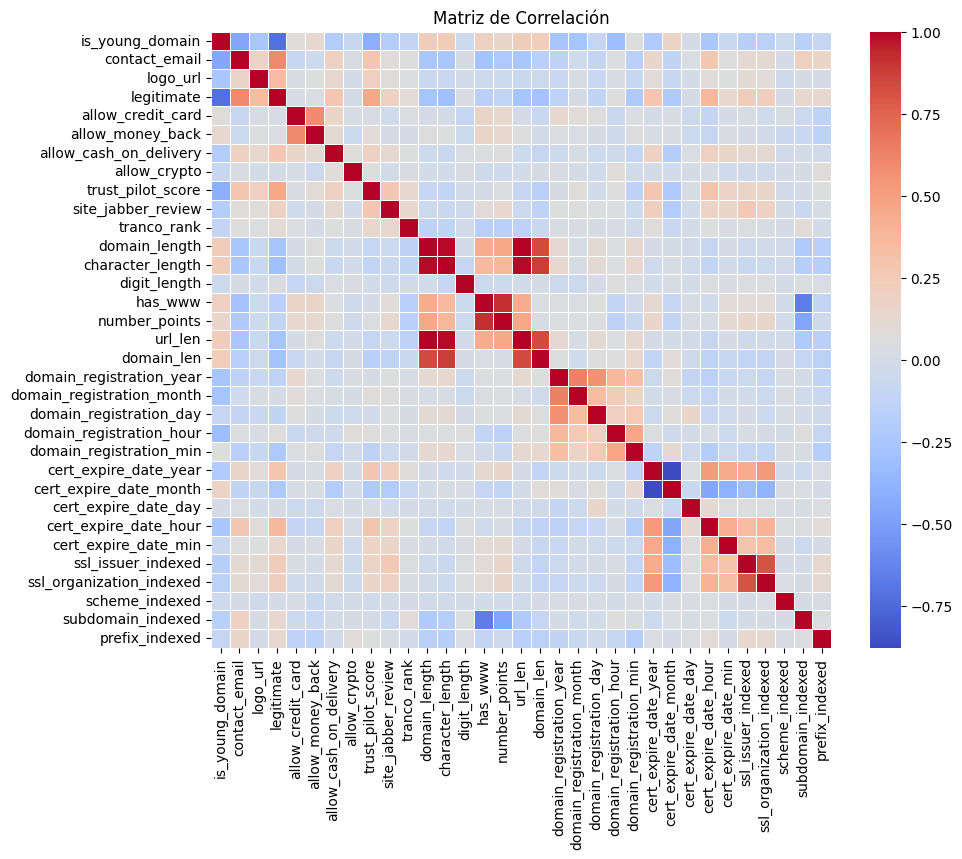

In [20]:
# Asegúrate de que las columnas de entrada estén correctamente definidas como un vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_vector = assembler.transform(corr_data).select("features")

# Verifica el tipo de datos de la columna "features"
df_vector.printSchema()

# Calcula la matriz de correlación
corr_matrix = Correlation.corr(df_vector, "features", method="pearson").head()[0]

# Convierte la matriz de correlación a un array de Numpy
corr_array = np.array(corr_matrix.toArray())

# Si los nombres de las columnas están disponibles en `feature_cols`, usa esos nombres en el gráfico
feature_names = feature_cols

# Convierte la matriz a un DataFrame de Pandas para usar con seaborn
corr_df = pd.DataFrame(corr_array, index=feature_names, columns=feature_names)

# Crea el gráfico de calor (heatmap) de la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

#### Mutual information

In [21]:
mi_data = new_data

In [22]:
mi_data_df = mi_data.toPandas()

/home/glue_user/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/home/glue_user/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [23]:
mi_data_df.iloc[0, :]

domain_url                   https://delozastore.de
domain_registration_date                        NaT
is_young_domain                                True
contact_email                                  True
logo_url                                       True
legitimate                                    False
allow_credit_card                             False
allow_money_back                               True
allow_cash_on_delivery                        False
allow_crypto                                  False
trust_pilot_score                               NaN
site_jabber_review                            False
tranco_rank                                      -1
ssl_issuer                                       R3
ssl_organization                      Let's Encrypt
cert_expire_date                2023-09-25 07:13:20
domain_length                                    22
character_length                                 18
digit_length                                      0
has_www     

In [24]:
mi_data_df.columns

Index(['domain_url', 'domain_registration_date', 'is_young_domain',
       'contact_email', 'logo_url', 'legitimate', 'allow_credit_card',
       'allow_money_back', 'allow_cash_on_delivery', 'allow_crypto',
       'trust_pilot_score', 'site_jabber_review', 'tranco_rank', 'ssl_issuer',
       'ssl_organization', 'cert_expire_date', 'domain_length',
       'character_length', 'digit_length', 'has_www', 'number_points',
       'scheme', 'subdomain', 'domain', 'prefix', 'url_len', 'domain_len',
       'domain_registration_year', 'domain_registration_month',
       'domain_registration_day', 'domain_registration_hour',
       'domain_registration_min', 'cert_expire_date_year',
       'cert_expire_date_month', 'cert_expire_date_day',
       'cert_expire_date_hour', 'cert_expire_date_min'],
      dtype='object')

In [25]:
X = mi_data_df.drop(columns=["legitimate"])
y = mi_data_df["legitimate"]

X = X.fillna(-1)

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

for colname in X.select_dtypes("bool"):
    X[colname] = X[colname].astype(np.int32)

y = y.astype(np.int32)

X = X.drop(columns=["domain_url", "domain_registration_date", "cert_expire_date"])
X.dtypes, y.dtypes

(is_young_domain                int32
 contact_email                  int32
 logo_url                       int32
 allow_credit_card              int32
 allow_money_back               int32
 allow_cash_on_delivery         int32
 allow_crypto                   int32
 trust_pilot_score            float64
 site_jabber_review             int32
 tranco_rank                    int32
 ssl_issuer                     int64
 ssl_organization               int64
 domain_length                  int32
 character_length               int32
 digit_length                   int32
 has_www                        int32
 number_points                  int32
 scheme                         int64
 subdomain                      int64
 domain                         int64
 prefix                         int64
 url_len                        int32
 domain_len                     int32
 domain_registration_year     float64
 domain_registration_month    float64
 domain_registration_day      float64
 domain_regi

In [26]:
discrete_features = X.columns != "trust_pilot_score"
discrete_features

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [27]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

domain                       0.833333
domain_registration_year     0.466522
ssl_issuer                   0.427121
prefix                       0.271526
is_young_domain              0.270533
ssl_organization             0.224101
contact_email                0.216485
trust_pilot_score            0.149749
character_length             0.134283
cert_expire_date_hour        0.110195
domain_registration_min      0.103140
domain_registration_hour     0.094262
url_len                      0.091875
domain_length                0.091875
domain_len                   0.090496
cert_expire_date_month       0.084965
cert_expire_date_min         0.073353
domain_registration_month    0.061639
allow_cash_on_delivery       0.050091
subdomain                    0.049876
logo_url                     0.046474
cert_expire_date_year        0.035606
site_jabber_review           0.030973
has_www                      0.024532
number_points                0.022108
digit_length                 0.003329
allow_crypto

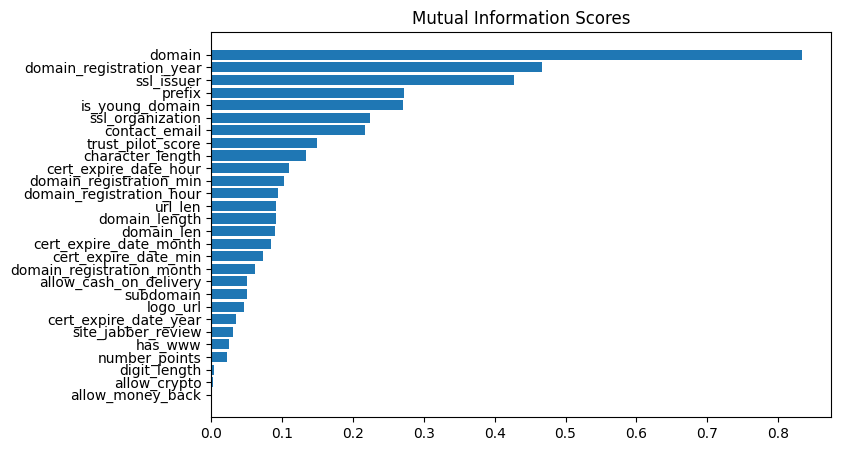

In [28]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores[:28])

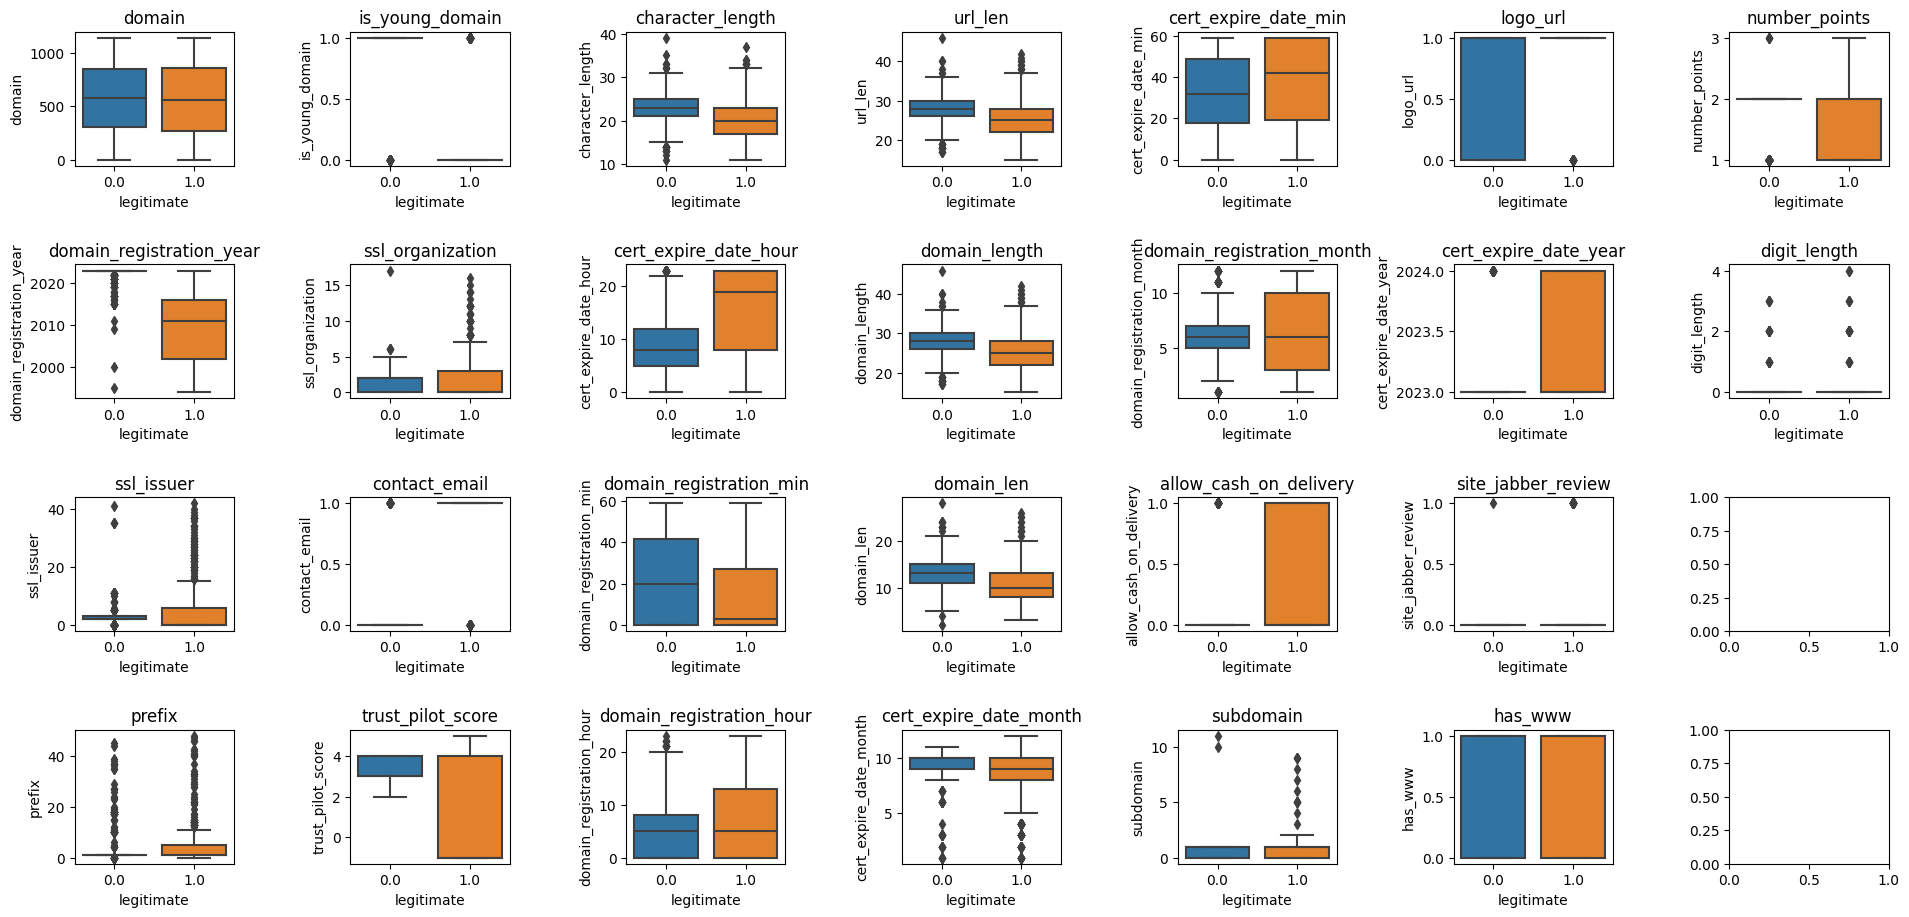

In [29]:
featured_cols = list(mi_scores[:26].index)

nrows = 4
fig, axs = plt.subplots( nrows, int(np.ceil(len(featured_cols)/nrows)), figsize=(20, 10) )

plt.tight_layout(pad=5.0)

for row_index, colname in enumerate(featured_cols):
    
    curr_ax = axs[row_index%nrows, row_index//nrows]
    
    data = mi_data_df[[colname, "legitimate"]].copy()
    
    if data[colname].dtype== object:
        data[colname], _ = data[colname].factorize()
    
    sns.boxplot(data=data.astype(float), x="legitimate", y=colname, ax=curr_ax);
    curr_ax.set_title(colname)


#### Write the data in the DynamicFrame to a location in Amazon S3

In [30]:
from awsglue.dynamicframe import DynamicFrame

glueContext.write_dynamic_frame.from_options(
    frame=DynamicFrame.fromDF(new_data.coalesce(1), glueContext, "random"),
    connection_type="s3",
    connection_options={"path": "s3://fraud-detection-data-ars/dataset"},
    format="csv",
    format_options={
        "quoteChar": -1,
    }
)

25/03/28 19:49:44 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
